## word2vec 속도 개선

이번 챕터에서는 word2vec의 속도를 개선하기 위해 2가지 기법을 도입한다.
첫번째 개선으로는 Embedding이라는 새로운 계층을 도입하며, 두번째 개선으로 네거티브 샘플링이라는 새로운 손실함수를 도입한다.

#### 1) Embedding 기법

3챕터의 word2vec 구현에서는 단어를 원핫 표현으로 바꿨다. 그러나 원핫 표현은
단어의 수가 많아질수록 행력의 크기가 커져서, 메모리 문제도 있고, 계산량도 증가하는 문제가 있다. 이러한 문제를 해결하기 위해 고안된 방식이 바로 Embedding 계층이다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None

  def forward(self, idx):
    W, = self.params
    self.idx = idx
    out = W[idx]
    return out

  def backward(self, dout):
    dW, = self.grads
    dW[...] = 0

    """
    for i, word_id in enumerate(self.idx):
      dW[word_id] += dout[i]
    """
    np.add.at(dW, self.idx, dout)
    return None

### 네거티브 샘플링

네거티브 샘플링은 '다중 분류'를 '이진 분류'로 근사시키는 것을 말한다.
예를 들어, 'you'와 'goodbye' 사이에 'say'가 와야한다면, 이전 챕터에서는
단어수 중 'say' index에만 정답 레이블을 설정하여 다중 분류 기법을 사용하였다.

그러나, 네거티브 샘플링에서는  'you'와 'goodbye'사이에 와야 하는 단어가 'say'입니까? 라는 질문에 대하여 '예' '아니오'로 답하는 이진 분류로 근사하여 문제를 해결한다.

In [ ]:
class EmbeddingDot:
  def __init__(self, W):
    self.embed = Embedding(W)
    self.params = self.embed.params
    self.grads = self.embed.grads
    self.cache = None

  def forward(self, h, idx):
    target_W = self.embed.forward(idx)
    out = np.sum(target_W * h, axis=1)
    
    self.cache = (h, target_W)
    return out
    
  def backward(self, dout):
    h, target_W = self.cache
    dout = dout.reshape(dout.shape[0], 1)

    dtarget_W = dout * h
    self.embed.backward(dtarget_W)
    dh = dout * target_W
    return dh

위 신경망은 긍정적 예인 'say'에 대해서만 학습하게 된다. 신경망은 'say'에 대해서는 1에 가까운 값을 출력해야 하고, 'say'이외의 단어에서는 0에 가까운 값을 출력해야 한다.

따라서, 긍정적 예인 'say'이외에도 부정적 예에 대하여 학습을 할 필요가 있다.
네거티브 샘플링에서는 여기서 통계적 기법을 활용하는데, 각 단어의 출현 빈도수를 확률 분포로 나타낸 뒤, 높은 확률값을 가진 단어 위주로 선정하여 부정적 예를 5개~10개 정도 고른 후, 학습을 시행한다.

In [ ]:
import collections

class UnigramSampler:
  def __init__(self, corpus, power, sample_size):
    self.corpus = corpus
    self.sample_size = sample_size
    self.vocab_size = None
    self.word_p = None

    counts = collections.Counter()
    for word_id in corpus:
      counts[word_id] += 1
    
    vocab_size = len(counts)
    self.vocab_size = vocab_size

    self.word_p = np.zeros(vocab_size)
    for i in range(vocab_size):
      self.word_p[i] = counts[i]

    self.word_p = np.power(self.word_p, power)
    self.word_p /= np.sum(self.word_p)

  def get_negative_sample(self, target):
    batch_size = target.shape[0]

    negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size), replace=True, p=self.word_p)
    return negative_sample

corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[1 4]
 [4 4]
 [0 2]]


### 네거티브 샘플링 구현

In [ ]:
# 교차 엔트로피 함수
def cross_entropy_error(y, t, eps=1e-7):
  if y.ndim == 1:
    y = y.reshape(1, y.size)
    t = t.reshape(1, t.size)

  if y.size == t.size:
    t = np.argmax(t, axis=1)

  batch_size = y.shape[0]
  return -np.sum(t * np.log(y[np.arange(batch_size), t] + eps)) / batch_size

# 시그모이드 + 손실함수
class SigmoidWithLoss:
  def __init__(self):
    self.params, self.grads = [], []
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.t = t
    self.y = 1 / (1 + np.exp(-x)) # sigmoid

    self.loss = cross_entropy_error(np.c_[1-self.y, self.y], self.t)
    return self.loss

  def backward(self, dout = 1):
    batch_size = self.t.shape[0]
    dx = (self.y - self.t) * dout / batch_size
    return dx

# 네거티브 샘플링
class NegativeSamplingLoss:
  def __init__(self, W, corpus, power=0.75, sample_size=5):
    self.sample_size = sample_size
    self.sampler = UnigramSampler(corpus, power, sample_size)
    self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
    self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

    self.params, self.grads = [], []
    for layer in self.embed_dot_layers:
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, h, target):
    batch_size = target.shape[0]
    negative_sample = self.sampler.get_negative_sample(target)

    # 긍정적 예 순전파
    score = self.embed_dot_layers[0].forward(h, target)
    correct_label = np.ones(batch_size, dtype=np.int32)
    loss = self.loss_layers[0].forward(score, correct_label)

    # 부정적 예 순전파
    negative_label = np.zeros(batch_size, dtype=np.int32)
    for i in range(self.sample_size):
      negative_target =  negative_sample[:, i]
      score = self.embed_dot_layers[i + 1].forward(h, negative_target)
      loss += self.loss_layers[i + 1].forward(score, negative_label)
    
    return loss

  def backward(self, dout=1):
    dh = 0
    for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
      dscore = l0.backward(dout)
      dh += l1.backward(dscore)

    return dh

### CBOW 모델 구현

In [ ]:
class CBOW:
  def __init__(self, vocab_size, hidden_size, window_size, corpus):
    V, H = vocab_size, hidden_size
    
    # 가중치 초기화
    W_in = 0.01 * np.random.randn(V, H).astype(np.float32)
    W_out = 0.01 * np.random.randn(V, H).astype(np.float32)

    # 계층 생성
    self.in_layers = []
    for i in range(window_size * 2):
      layer = Embedding(W_in)
      self.in_layers.append(layer)
    self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
    layers = self.in_layers + [self.ns_loss]

    # 모든 가중치와 기울기를 배열에 모은다.
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    self.word_vecs = W_in

  def forward(self, contexts, target):
    h = 0
    for i, layer in enumerate(self.in_layers):
      h += layer.forward(contexts[:, i])
    h *= 1 / len(self.in_layers)
    loss = self.ns_loss.forward(h, target)
    return loss

  def backward(self, dout=1):
    dout = self.ns_loss.backward(dout)
    dout *= 1 / len(self.in_layers)
    for layer in self.in_layers:
      layer.backward(dout)
    return None

### CBOW 모델 학습

CBOW 모델을 활용하여 학습을 진행해본다.
일단 PTB 데이터 셋으로 대량 데이터 학습을 진행하기 위해서,
데이터를 불러오는 코드를 작성한다.

In [ ]:
# coding: utf-8
import sys
import os
sys.path.append('..')

import urllib.request
import pickle
import numpy as np

url_base = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/'
key_file = {
    'train':'ptb.train.txt',
    'test':'ptb.test.txt',
    'valid':'ptb.valid.txt'
}
save_file = {
    'train':'ptb.train.npy',
    'test':'ptb.test.npy',
    'valid':'ptb.valid.npy'
}
vocab_file = 'ptb.vocab.pkl'

dataset_dir = '/content'

def _download(file_name):
  file_path = dataset_dir + '/' + file_name
  if os.path.exists(file_path):
    return

  print('Downloading ' + file_name + ' ... ')

  try:
    urllib.request.urlretrieve(url_base + file_name, file_path)
  except urllib.error.URLError:
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context
    urllib.request.urlretrieve(url_base + file_name, file_path)

  print('Done')

def load_vocab():
  vocab_path = dataset_dir + '/' + vocab_file

  if os.path.exists(vocab_path):
    with open(vocab_path, 'rb') as f:
      word_to_id, id_to_word = pickle.load(f)
    return word_to_id, id_to_word

  word_to_id = {}
  id_to_word = {}
  data_type = 'train'
  file_name = key_file[data_type]
  file_path = dataset_dir + '/' + file_name

  _download(file_name)

  words = open(file_path).read().replace('\n', '<eos>').strip().split()

  for i, word in enumerate(words):
    if word not in word_to_id:
      tmp_id = len(word_to_id)
      word_to_id[word] = tmp_id
      id_to_word[tmp_id] = word

  with open(vocab_path, 'wb') as f:
    pickle.dump((word_to_id, id_to_word), f)

  return word_to_id, id_to_word

def load_data(data_type='train'):
  if data_type == 'val': 
    data_type = 'valid'
  save_path = dataset_dir + '/' + save_file[data_type]

  word_to_id, id_to_word = load_vocab()

  if os.path.exists(save_path):
    corpus = np.load(save_path)
    return corpus, word_to_id, id_to_word

  file_name = key_file[data_type]
  file_path = dataset_dir + '/' + file_name
  _download(file_name)

  words = open(file_path).read().replace('\n', '<eos>').strip().split()
  corpus = np.array([word_to_id[w] for w in words])

  np.save(save_path, corpus)
  return corpus, word_to_id, id_to_word

corpus, word_to_id, id_to_word = load_data()

학습에 필요한 Trainer() 클래스와, optimizer를 코딩한다.

In [ ]:
import time

# 중복된 가중치 제거
def remove_duplicate(params, grads):
  '''
  매개변수 배열 중 중복되는 가중치를 하나로 모아
  그 가중치에 대응하는 기울기를 더한다.
   '''
  params, grads = params[:], grads[:]  # copy list

  while True:
    find_flg = False
    L = len(params)

    for i in range(0, L - 1):
      for j in range(i + 1, L):
        # 가중치 공유 시
        if params[i] is params[j]:
          grads[i] += grads[j]  # 경사를 더함
          find_flg = True
          params.pop(j)
          grads.pop(j)
        # 가중치를 전치행렬로 공유하는 경우(weight tying)
        elif params[i].ndim == 2 and params[j].ndim == 2 and \
          params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
          grads[i] += grads[j].T
          find_flg = True
          params.pop(j)
          grads.pop(j)

        if find_flg: break
      if find_flg: break

    if not find_flg: break

  return params, grads

def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

# trainer (fit, 배치 생성, plot 역할을 한다.)
class Trainer:
  def __init__(self, model, optimizer):
    self.model = model
    self.optimizer = optimizer
    self.loss_list = []
    self.eval_interval = None
    self.current_epoch = 0

  def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
    data_size = len(x)
    max_iters = data_size // batch_size
    self.eval_interval = eval_interval
    model, optimizer = self.model, self.optimizer
    total_loss = 0
    loss_count = 0

    for epoch in range(max_epoch):
      # 뒤섞기
      idx = np.random.permutation(np.arange(data_size))
      x = x[idx]
      t = t[idx]

      start_time = time.time()
      avg_loss, elapsed_time = 0, 0
      for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        # 기울기 구해 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
        """
        if max_grad is not None:
          clip_grads(grads, max_grad)
        """
        optimizer.update(params, grads)
        total_loss += loss
        loss_count += 1

        # 평가
        if (eval_interval is not None) and (iters % eval_interval) == 0:
          avg_loss = total_loss / loss_count
          self.loss_list.append(float(avg_loss))
          total_loss, loss_count = 0, 0

      elapsed_time = time.time() - start_time
      print('| 에폭 %d | 시간 %d[s] | 손실 %.2f' % (self.current_epoch + 1, elapsed_time, avg_loss))
      self.current_epoch += 1

  def plot(self, ylim=None):
    x = np.arange(len(self.loss_list))
    if ylim is not None:
      plt.ylim(*ylim)
    plt.plot(x, self.loss_list, label='train')
    plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

# adam optimizer
class Adam:
  def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.iter = 0
    self.m = None
    self.v = None
        
  def update(self, params, grads):
    if self.m is None:
      self.m, self.v = [], []
      for param in params:
        self.m.append(np.zeros_like(param))
        self.v.append(np.zeros_like(param))
        
    self.iter += 1
    lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

    for i in range(len(params)):
      self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
      self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
      params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

CBOW 모델 학습 코드를 작성한다.

| 에폭 1 | 시간 447[s] | 손실 1.44
| 에폭 2 | 시간 438[s] | 손실 1.24
| 에폭 3 | 시간 447[s] | 손실 1.18
| 에폭 4 | 시간 445[s] | 손실 1.12
| 에폭 5 | 시간 441[s] | 손실 1.03
| 에폭 6 | 시간 438[s] | 손실 1.01
| 에폭 7 | 시간 439[s] | 손실 0.95
| 에폭 8 | 시간 437[s] | 손실 0.92
| 에폭 9 | 시간 433[s] | 손실 0.88
| 에폭 10 | 시간 437[s] | 손실 0.85


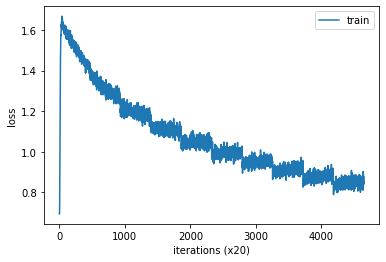

In [ ]:
# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

# 모델 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
  pickle.dump(params, f, -1)

위에서 학습한 단어의 분산표현 성능을 평가해보겠다.

In [8]:
# 코사인 유사도
def cos_similarity(x, y, eps=1e-8):
  nx = x / (np.sqrt(np.sum(x**2)) + eps)
  ny = y / (np.sqrt(np.sum(y**2)) + eps)
  return np.dot(nx, ny)

def most_similar(query, word_to_id, id_to_word, word_vecs, top=5):
  if query not in word_to_id:
    print("%s을 찾을 수 없습니다." % query)
    return

  print("\n[query] " + query)
  query_id = word_to_id[query]
  query_vec = word_vecs[query_id]

  # 코사인 유사도 계산
  vocab_size = len(word_to_id)

  similarity = np.zeros(vocab_size)
  for i in range(vocab_size):
    similarity[i] = cos_similarity(query_vec, word_vecs[i])

  # 코사인 유사도를 기준으로 내림차순으로 출력
  count = 0
  for i in (-1 * similarity).argsort():
    if id_to_word[i] == query:
      continue
    print(' %s: %s' % (id_to_word[i], similarity[i]))

    count += 1
    if count >= top:
      return


pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
  params = pickle.load(f)

  word_vecs = params['word_vecs']
  word_to_id = params['word_to_id']
  id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 i: 0.7119140625
 we: 0.7099609375
 they: 0.61962890625
 your: 0.603515625
 anything: 0.57421875

[query] year
 month: 0.875
 week: 0.78955078125
 spring: 0.76708984375
 summer: 0.7607421875
 decade: 0.68798828125

[query] car
 luxury: 0.6337890625
 auto: 0.609375
 cars: 0.58740234375
 window: 0.57177734375
 merkur: 0.5712890625

[query] toyota
 engines: 0.6484375
 mazda: 0.607421875
 weyerhaeuser: 0.6015625
 compact: 0.60009765625
 marathon: 0.59619140625


### 유추 문제 풀기

word2vec으로 얻은 단어의 분산 표현은 비슷한 단어를 가까이 모을 뿐 아니라, 더 복잡한 패턴을 파악하는 것으로 알려져 있다. 대표적인 예가 'king - man + woman = queen' 같은 문제이다. analogy 함수를 활용하여 다음과 같은 문제를 해결해보겠다.

In [18]:
def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
  for word in (a, b, c):
    if word not in word_to_id:
      print('%s(을)를 찾을 수 없습니다.' % word)
      return

  print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
  a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
  query_vec = b_vec - a_vec + c_vec
  query_vec = normalize(query_vec)

  similarity = np.dot(word_matrix, query_vec)

  if answer is not None:
    print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

  count = 0
  for i in (-1 * similarity).argsort():
    if np.isnan(similarity[i]):
      continue
    if id_to_word[i] in (a, b, c):
      continue
    print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

    count += 1
    if count >= top:
      return

def normalize(x):
  if x.ndim == 2:
    s = np.sqrt((x * x).sum(1))
    x /= s.reshape((s.shape[0], 1))
  elif x.ndim == 1:
    s = np.sqrt((x * x).sum())
    x /= s
  return x

analogy('king', 'man', 'queen', word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad', word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 woman: 5.5859375
 kid: 4.859375
 mother: 4.74609375
 cubans: 4.625
 hacker: 4.59765625

[analogy] take:took = go:?
 were: 4.703125
 came: 4.62109375
 was: 4.41796875
 're: 4.2578125
 went: 4.09375

[analogy] car:cars = child:?
 a.m: 6.41015625
 rape: 5.68359375
 children: 5.6171875
 daffynition: 4.87109375
 incest: 4.8515625

[analogy] good:better = bad:?
 rather: 5.7890625
 more: 5.5703125
 less: 5.34765625
 greater: 4.34765625
 faster: 4.18359375
